In [1]:
import sys
import os
sys.path.append(os.path.abspath('../'))

import itertools
from evaluation import *
from data_loader import *
import random
from datetime import datetime
import numpy as np
from datetime import timedelta

In [2]:
colors = {
    "DQN": 'darkorange',
    "REINFORCE": 'forestgreen',
    "CMA-ES": 'cyan',
    "CMA": 'cyan',
    "ODT": 'blueviolet'
}

In [3]:
experiments = list(itertools.chain(
    range(4000, 4180),
    range(5000, 5180),
    range(6000, 6180),
))
target_agg_count = 10

exp_power_data = []

for ind, exp_num in enumerate(experiments):
    config_fname = f'./Exp_{exp_num}/config.yaml'
    
    c = load_config_file(config_fname)
    nn_c = c['nn_hyperparameters']
    federated_c = c['federated_learning_settings']
    algo_c = c['algorithm_settings']

    if algo_c == 'ODT':
        target_agg_count = 4
    
    env_c = c['environment_settings']
    eval_c = c['eval_config']

    # if federated_c['aggregation_count'] != target_agg_count and target_agg_count != None:
    #     print(f"Experiment {exp_num} does not have matching aggregation level")
    #     continue
    
    ev_info = []

    seed = env_c['seed']

    algorithm_dm = algo_c['algorithm']
    
    def load_from_json_with_error_handling(filepath, columns_specific):
        try:
            return read_csv_data(filepath, columns=columns_specific)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON from {filepath}: {e.msg} at line {e.lineno}, column {e.colno}")
            return None  # Handle the error and return None or an empty object
    
    
    d_base = f"../../../../storage_1/metrics/Exp_{exp_num}"
    
    if not os.path.exists(d_base):
        d_base = f"../metrics/Exp_{exp_num}"
            
    base_path = f"{d_base}/train/"

    print(f'Loading {base_path}power_and_co2_metrics.csv')
    power_data = load_from_json_with_error_handling(f'{base_path}power_and_co2_metrics.csv', ['time', 'power', 'co2'])
    
    power_data['seed'] = seed
    power_data['exp_num'] = exp_num
    
    power_data['algorithm'] = algorithm_dm
    power_data['season'] = env_c['season']
    power_data['num_aggs'] = federated_c['aggregation_count']
    power_data['eps_per_agg'] = nn_c['num_episodes']

    exp_power_data.append(power_data)

Loading ../../../../storage_1/metrics/Exp_4000/train/power_and_co2_metrics.csv
Loading ../../../../storage_1/metrics/Exp_4001/train/power_and_co2_metrics.csv
Loading ../../../../storage_1/metrics/Exp_4002/train/power_and_co2_metrics.csv
Loading ../../../../storage_1/metrics/Exp_4003/train/power_and_co2_metrics.csv
Loading ../../../../storage_1/metrics/Exp_4004/train/power_and_co2_metrics.csv
Loading ../../../../storage_1/metrics/Exp_4005/train/power_and_co2_metrics.csv
Loading ../../../../storage_1/metrics/Exp_4006/train/power_and_co2_metrics.csv
Loading ../../../../storage_1/metrics/Exp_4007/train/power_and_co2_metrics.csv
Loading ../../../../storage_1/metrics/Exp_4008/train/power_and_co2_metrics.csv
Loading ../../../../storage_1/metrics/Exp_4009/train/power_and_co2_metrics.csv
Loading ../../../../storage_1/metrics/Exp_4010/train/power_and_co2_metrics.csv
Loading ../../../../storage_1/metrics/Exp_4011/train/power_and_co2_metrics.csv
Loading ../../../../storage_1/metrics/Exp_4012/train

In [4]:
# Convert data to DataFrame for easier manipulation
df_power = pd.concat(exp_power_data, ignore_index=True)

df_power.head()

,time,power,co2,seed,exp_num,algorithm,season,num_aggs,eps_per_agg
0,2025-03-21 19:42:02,29.3,0.000449,1234,4000,DQN,spring,50,200
1,2025-03-21 19:45:33,27.7,0.000449,1234,4000,DQN,spring,50,200
2,2025-03-21 19:49:04,27.8,0.000449,1234,4000,DQN,spring,50,200
3,2025-03-21 19:52:35,27.9,0.000449,1234,4000,DQN,spring,50,200
4,2025-03-21 19:56:06,27.9,0.000449,1234,4000,DQN,spring,50,200


In [5]:
# Calculate cumulative power for each experiment and add it as a new column
df_power['cumulative_power'] = df_power.groupby('exp_num')['power'].cumsum()

df_power['time'] = pd.to_datetime(df_power['time'], errors='coerce')
df_power['time'] = df_power.groupby('exp_num')['time'].transform(lambda x: (x - x.min()).dt.total_seconds())

df_power['co2'] = df_power['co2'] * 1000 # Convert to grams

# Convert 3 aggs to 1 for CMA
df_power['num_aggs'] = np.where(
    (df_power['num_aggs'] == 3) & 
    (df_power['algorithm'] == 'CMA'), 
    1, 
    df_power['num_aggs']
)

# Display the first few rows of the updated DataFrame
df_power.head()

,time,power,co2,seed,exp_num,algorithm,season,num_aggs,eps_per_agg,cumulative_power
0,0.0,29.3,0.449398,1234,4000,DQN,spring,50,200,29.3
1,211.0,27.7,0.449398,1234,4000,DQN,spring,50,200,57.0
2,422.0,27.8,0.449398,1234,4000,DQN,spring,50,200,84.8
3,633.0,27.9,0.449398,1234,4000,DQN,spring,50,200,112.7
4,844.0,27.9,0.449398,1234,4000,DQN,spring,50,200,140.6


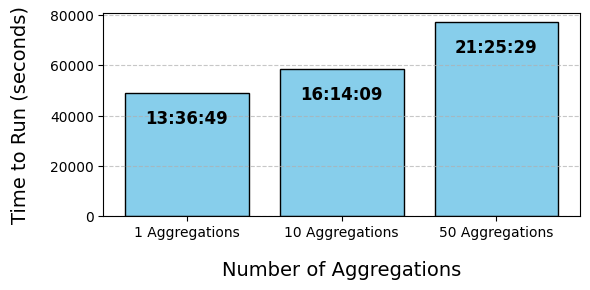

In [6]:
# Display average time to completion for each aggregation level
final_times = df_power.groupby('exp_num')['time'].max().reset_index()
final_times.rename(columns={'time': 'final_time'}, inplace=True)

final_times = final_times.merge(df_power[['exp_num', 'num_aggs']].drop_duplicates(), on='exp_num')

average_final_time = final_times.groupby('num_aggs')['final_time'].mean().reset_index()

average_final_time['agg_label'] = average_final_time['num_aggs'].apply(lambda x: f"{x} Aggregations")

def seconds_to_hms(seconds):
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    secs = seconds % 60
    return f"{int(hours):02}:{int(minutes):02}:{int(secs):02}"

plt.figure(figsize=(6, 3))
bars = plt.bar(average_final_time['agg_label'], average_final_time['final_time'], 
               color='skyblue', edgecolor='black')
#plt.title('Average Final Time by Number of Aggregations', fontsize=18, pad=15)
plt.ylabel('Time to Run (seconds)', fontsize=14, labelpad=15)
plt.xlabel('Number of Aggregations', fontsize=14, labelpad=15)
for bar in bars:
    height = bar.get_height()
    hms = seconds_to_hms(height)
    plt.annotate(hms,
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, -25),  # 5 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

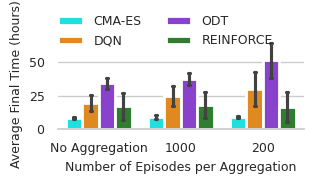

In [7]:
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    'font.size': 9,
    'axes.titlesize': 9,
    'axes.labelsize': 9,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9
})

# Compute the final time per experiment
final_times = (
    df_power
    .groupby(['exp_num', 'num_aggs', 'algorithm'])['time']
    .max()
    .reset_index()
)

# Convert 'num_aggs' to string for labeling
final_times['num_aggs_str'] = final_times['num_aggs'].astype(str)

# Convert seconds to hours
final_times['time'] = final_times['time'] / 3600  

# Standardize algorithm names
final_times['algorithm'] = final_times['algorithm'].replace('CMA', 'CMA-ES')

# Offset ODT by the mean DQN duration
mean_dqn = final_times.loc[final_times['algorithm'] == 'DQN', 'time'].mean()
final_times.loc[final_times['algorithm'] == 'ODT', 'time'] += mean_dqn

# --- map all three aggregation levels to human‐readable labels ---
label_map = {
    '1':  'No Aggregation',
    '10': '1000',
    '50': '200'
}
final_times['num_aggs_label'] = final_times['num_aggs_str'].map(label_map)

# define the plotting order of the x‐axis
agg_labels_ordered = [label_map[k] for k in sorted(label_map.keys(), key=int)]

# determine hue order
algorithms = sorted(final_times['algorithm'].unique())

g = sns.catplot(
    data=final_times,
    kind="bar",
    x="num_aggs_label",
    y="time",
    hue="algorithm",
    order=agg_labels_ordered,
    hue_order=algorithms,
    errorbar="sd",
    palette=colors,
    alpha=1,
    height=1.75,
    aspect=1.8,
    capsize=0.1,
    linewidth=2
)

# move legend, etc.
g.despine(left=True)
g.set_axis_labels("Number of Episodes per Aggregation", "Average Final Time (hours)")
# remove the auto‐created legend
if g._legend:
    g._legend.remove()

# grab the first (and only) Axes of the FacetGrid
ax = g.axes.flatten()[0]

# fetch the handles & labels from that axes
handles, labels = ax.get_legend_handles_labels()

# draw a new legend with 2 columns, no title, and positioned upper‐left
ax.legend(
    handles, labels,
    ncol=2,
    loc='upper left',
    bbox_to_anchor=(0, 1),
    title=None,
    fontsize=1
)

# 1) Grab the FacetGrid’s single Axes
ax = g.axes.flatten()[0]

# 2) Pull out the existing handles & labels, then remove the in-axes legend
handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()

# 3) Place a 2×2 legend above the plot (fig-level)
g.fig.legend(
    handles, labels,
    ncol=2,
    loc='upper center',
    bbox_to_anchor=(0.4, 1.05),  # 5% above the top
    frameon=False,
    fontsize=9
)

# 4) Expand the top and left margins so nothing is clipped
g.fig.subplots_adjust(
    top=0.85,    # make room at top for legend
    left=0.15    # give extra space for y-label
)
plt.savefig('./Figures/training_durations_Ethan5.png', dpi=300, bbox_inches='tight')
plt.show()


In [8]:
# Filter the final_times DataFrame for num_aggs == '6'
agg_6 = final_times[final_times['num_aggs'] == '10'].copy()

# Convert 'time' from seconds to hours
agg_6['time_hours'] = agg_6['time'] / 3600  # 3600 seconds in an hour

# Group by 'algorithm' and calculate mean and standard deviation of 'time_hours'
stats = agg_6.groupby('algorithm')['time_hours'].agg(['mean', 'std']).reset_index()

# Rename columns for clarity
stats.rename(columns={'mean': 'Mean Training Time (hours)', 'std': 'Std Dev (hours)'}, inplace=True)

# Print the results
print("\nMean and Standard Deviation of Training Time by Algorithm (num_aggs == 6):")
print(stats.to_string(index=False))


Mean and Standard Deviation of Training Time by Algorithm (num_aggs == 6):
Empty DataFrame
Columns: [algorithm, Mean Training Time (hours), Std Dev (hours)]
Index: []


In [9]:
# Function to calculate energy in kWh for a single experiment
def calculate_energy_kWh(exp_data):
    # Sort the data by elapsed time
    exp_data_sorted = exp_data.sort_values('time')
    
    # Extract power (W) and time (s)
    power = exp_data_sorted['power'].values  # Power in W
    time_sec = exp_data_sorted['time'].values  # Time in seconds
    
    # Convert time to hours for integration
    time_hours = time_sec / 3600  # Convert seconds to hours
    
    # Handle cases where time_hours may not be strictly increasing
    # Ensure that time_hours is sorted and unique
    if not np.all(np.diff(time_hours) >= 0):
        raise ValueError("Time data must be sorted and non-decreasing for integration.")
    
    # Integrate power over time using the trapezoidal rule to get energy in Wh
    energy_Wh = np.trapz(power, time_hours)  # Integration: ∫ P(t) dt
    
    # Convert Wh to kWh
    energy_kWh = energy_Wh / 1000
    
    return energy_kWh

# Iterate over each unique algorithm in the DataFrame
for algo in df_power['algorithm'].unique():
    # Filter data for the current algorithm
    algo_data = df_power[df_power['algorithm'] == algo]
    
    # Group by 'exp_num' to process each experiment separately
    grouped = algo_data.groupby('exp_num')
    
    # Initialize lists to store energy and CO2 for each experiment
    energy_kWh_list = []
    co2_list = []
    
    # Iterate over each experiment within the algorithm
    for exp_num, exp_data in grouped:
        try:
            # Calculate energy in kWh for the experiment
            energy_kWh = calculate_energy_kWh(exp_data)
            energy_kWh_list.append(energy_kWh)
            
            # Assume 'co2' is recorded at each time point; take the last entry as total CO2
            co2_total = exp_data['co2'].iloc[-1]
            co2_list.append(co2_total)
        except ValueError as e:
            print(f"Error processing Algorithm {algo}, Experiment {exp_num}: {e}")
    
    # Convert lists to NumPy arrays for statistical calculations
    energy_kWh_array = np.array(energy_kWh_list)
    co2_array = np.array(co2_list)
    
    # Calculate mean and standard deviation for energy
    avg_energy_kWh = energy_kWh_array.mean()
    std_energy_kWh = energy_kWh_array.std()
    
    # Calculate mean and standard deviation for CO2 emissions
    avg_co2 = co2_array.mean()
    std_co2 = co2_array.std()
    
    # Print the metrics with updated units
    print(f"Algorithm {algo} Power and CO2 Metrics")
    print(f"\tAverage energy used per experiment: {avg_energy_kWh:.4f} kWh")
    print(f"\tStandard deviation of energy used per experiment: {std_energy_kWh:.4f} kWh")
    print(f"\tAverage CO2 estimated emissions per experiment: {avg_co2:.4f} g")
    print(f"\tStandard deviation of CO2 estimated emissions per experiment: {std_co2:.4f} g\n")

Algorithm DQN Power and CO2 Metrics
	Average energy used per experiment: 0.8631 kWh
	Standard deviation of energy used per experiment: 0.3345 kWh
	Average CO2 estimated emissions per experiment: 0.4327 g
	Standard deviation of CO2 estimated emissions per experiment: 0.1674 g

Algorithm REINFORCE Power and CO2 Metrics
	Average energy used per experiment: 0.5836 kWh
	Standard deviation of energy used per experiment: 0.3567 kWh
	Average CO2 estimated emissions per experiment: 0.3506 g
	Standard deviation of CO2 estimated emissions per experiment: 0.1262 g

Algorithm CMA Power and CO2 Metrics
	Average energy used per experiment: 0.3654 kWh
	Standard deviation of energy used per experiment: 0.0643 kWh
	Average CO2 estimated emissions per experiment: 0.1852 g
	Standard deviation of CO2 estimated emissions per experiment: 0.0284 g

Algorithm ODT Power and CO2 Metrics
	Average energy used per experiment: 4.3478 kWh
	Standard deviation of energy used per experiment: 2.3685 kWh
	Average CO2 esti

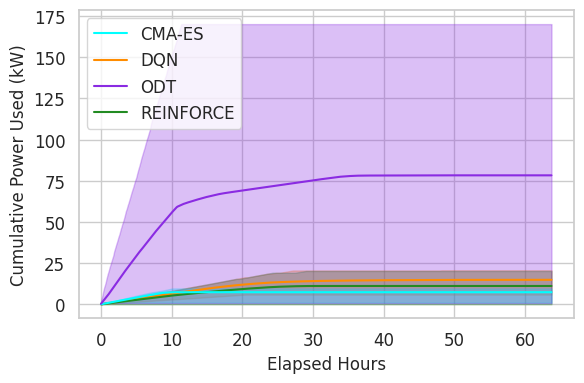

In [10]:
plt.figure(figsize=(6, 4))

plt.rcParams.update({
    'font.size':        12,
    'axes.titlesize':   12,
    'axes.labelsize':   12,
    'xtick.labelsize':  12,
    'ytick.labelsize':  12,
    'legend.fontsize':  12
})
t_min = df_power['time'].min()
t_max = df_power['time'].max()
time_grid = np.linspace(t_min, t_max, num=1000)

for algo in df_power['algorithm'].unique():
    algo_data = df_power[df_power['algorithm'] == algo]
    experiments = algo_data['exp_num'].unique()
    interp_cumulative_powers = []

    for exp in experiments:
        exp_data = algo_data[algo_data['exp_num'] == exp].sort_values('time')
        exp_time  = exp_data['time'].values
        exp_cum   = exp_data['cumulative_power'].values
        max_cum   = exp_cum[-1]

        interp = np.interp(
            time_grid, exp_time, exp_cum,
            left=0, right=max_cum
        )
        interp_cumulative_powers.append(interp)

    interp_array = np.array(interp_cumulative_powers)
    min_cp = np.min(interp_array, axis=0)
    max_cp = np.max(interp_array, axis=0)
    mean_cp= np.mean(interp_array, axis=0)

    # 1) convert to kW
    min_cp_kW  = min_cp  / 1000.0
    max_cp_kW  = max_cp  / 1000.0
    mean_cp_kW = mean_cp / 1000.0

    time_hours = time_grid / 3600.0

    plt.fill_between(
        time_hours,
        min_cp_kW,
        max_cp_kW,
        color=colors[algo], alpha=0.3
    )
    name = 'CMA-ES' if algo=='CMA' else algo
    plt.plot(
        time_hours,
        mean_cp_kW,
        color=colors[algo],
        label=f'{name}'
    )

# legend
handles, labels = plt.gca().get_legend_handles_labels()
labels_handles = sorted(zip(labels, handles), key=lambda x: x[0])
labels_sorted, handles_sorted = zip(*labels_handles)
plt.legend(handles_sorted, labels_sorted, loc='upper left')

plt.xlabel('Elapsed Hours')
# 2) update the unit to kW
plt.ylabel('Cumulative Power Used (kW)')
plt.grid(True)
plt.tight_layout()

plt.savefig('./Figures/power_used_Ethan2.png', dpi=300, bbox_inches='tight')
plt.show()


  exp 4003: final cumulative_power = 17702 (raw units)
  exp 4004: final cumulative_power = 17929 (raw units)
  exp 4005: final cumulative_power = 17122 (raw units)
  exp 4012: final cumulative_power = 14267 (raw units)
  exp 4013: final cumulative_power = 15695 (raw units)
  exp 4014: final cumulative_power = 15771 (raw units)
  exp 4021: final cumulative_power = 16611 (raw units)
  exp 4022: final cumulative_power = 18676 (raw units)
  exp 4023: final cumulative_power = 15560 (raw units)
  exp 4030: final cumulative_power = 14592 (raw units)
  exp 4031: final cumulative_power = 12714 (raw units)
  exp 4032: final cumulative_power = 14220 (raw units)
  exp 5003: final cumulative_power = 18661 (raw units)
  exp 5004: final cumulative_power = 17234 (raw units)
  exp 5005: final cumulative_power = 18582 (raw units)
  exp 5012: final cumulative_power = 16445 (raw units)
  exp 5013: final cumulative_power = 14801 (raw units)
  exp 5014: final cumulative_power = 15511 (raw units)
  exp 5021

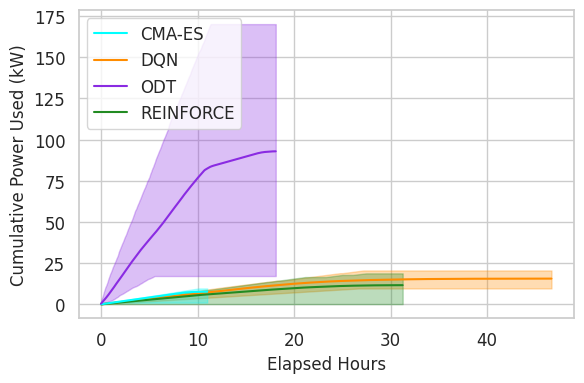

In [34]:
plt.figure(figsize=(6, 4))

plt.rcParams.update({
    'font.size':        12,
    'axes.titlesize':   12,
    'axes.labelsize':   12,
    'xtick.labelsize':  12,
    'ytick.labelsize':  12,
    'legend.fontsize':  12
})

mask = df_power.num_aggs == 10

df_10aggs = df_power.loc[mask,:]
#exp 4129: final cumulative_power = 782 (raw units)
mask2 = df_10aggs.exp_num != 4129

df_10aggs2 = df_10aggs.loc[mask2,:]



for algo in df_10aggs2['algorithm'].unique():
    algo_data    = df_10aggs2[df_10aggs2['algorithm'] == algo]
    experiments  = algo_data['exp_num'].unique()

    # per‐algorithm time bounds
    t_min_algo   = algo_data['time'].min()
    t_max_algo   = algo_data['time'].max()
    time_grid    = np.linspace(t_min_algo, t_max_algo, num=1000)
    time_hours   = time_grid / 3600.0

    interp_cumulative_powers = []
    
    for exp in experiments:
        exp_data = algo_data[algo_data['exp_num'] == exp].sort_values('time')
        exp_time = exp_data['time'].values
        final_cum = exp_data['cumulative_power'].iloc[-1]
        print(f"  exp {exp}: final cumulative_power = {final_cum:.0f} (raw units)")
        exp_cum  = exp_data['cumulative_power'].values
        max_cum  = exp_cum[-1]

        interp = np.interp(
            time_grid, exp_time, exp_cum,
            left=0, right=max_cum
        )
        interp_cumulative_powers.append(interp)

    interp_array = np.array(interp_cumulative_powers)
    min_cp = np.min(interp_array, axis=0) / 1000.0
    max_cp = np.max(interp_array, axis=0) / 1000.0
    mean_cp= np.mean(interp_array,axis=0) / 1000.0

    # print final elapsed hour and min/max power at that time
    final_hour   = time_hours[-1]
    final_min    = min_cp[-1]
    final_max    = max_cp[-1]
    print(f"{algo}: final elapsed = {final_hour:.2f} h; "
          f"min final power = {final_min:.2f} kW; "
          f"max final power = {final_max:.2f} kW")

    # plotting
    plt.fill_between(
        time_hours,
        min_cp,
        max_cp,
        color=colors[algo], alpha=0.3
    )
    name = 'CMA-ES' if algo=='CMA' else algo
    plt.plot(
        time_hours,
        mean_cp,
        color=colors[algo],
        label=name
    )

# sort legend alphabetically
handles, labels = plt.gca().get_legend_handles_labels()
labels_handles = sorted(zip(labels, handles), key=lambda x: x[0])
labels_sorted, handles_sorted = zip(*labels_handles)
plt.legend(handles_sorted, labels_sorted, loc='upper left')

plt.xlabel('Elapsed Hours')
plt.ylabel('Cumulative Power Used (kW)')
plt.grid(True)
plt.tight_layout()

plt.savefig('./Figures/power_used_Ethan2.png', dpi=300, bbox_inches='tight')
plt.show()


In [21]:
df_power.num_aggs.unique()

array([50, 10,  1])

In [32]:
mask = df_power.num_aggs == 10

df_10aggs = df_power.loc[mask,:]
#exp 4129: final cumulative_power = 782 (raw units)
mask2 = df_10aggs.exp_num != 4129

df_10aggs2 = df_10aggs.loc[mask2,:]




In [33]:
df_10aggs2.head()

,time,power,co2,seed,exp_num,algorithm,season,num_aggs,eps_per_agg,cumulative_power
1472,0.0,34.8,0.651213,1234,4003,DQN,spring,10,1000,34.8
1473,265.0,34.9,0.651213,1234,4003,DQN,spring,10,1000,69.7
1474,530.0,35.0,0.651213,1234,4003,DQN,spring,10,1000,104.7
1475,795.0,35.3,0.651213,1234,4003,DQN,spring,10,1000,140.0
1476,1060.0,35.3,0.651213,1234,4003,DQN,spring,10,1000,175.3


/home/epigou/miniconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/epigou/miniconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/epigou/miniconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/epigou/miniconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/hom

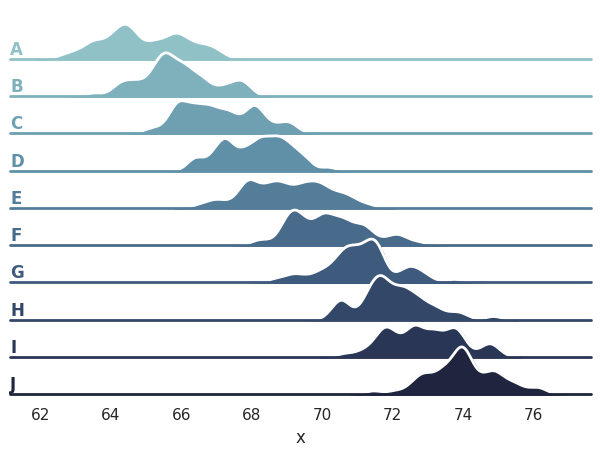

In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
rs = np.random.RandomState(1979)
x = rs.randn(500)
g = np.tile(list("ABCDEFGHIJ"), 50)
df = pd.DataFrame(dict(x=x, g=g))
m = df.g.map(ord)
df["x"] += m

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "x")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)